In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
#import calendar
#import operator
import sys
import yodiipy.ANSStools as atp
#
# TODO: it is probably time to say goodnight to Python 2.x support...
import urllib
# try:
# 	# should work with python 3.x
# 	import urllib.request, urllib.parse, urllib.error
# except:
# 	print("failed while loading: urllib.request, urllib.parse, urllib.error.\n probably Python 2.x?")
# 	#urllib.request.urlopen = urllib.urlopen

# try:
# 	import ullib2
# except:
# 	print("failed while loading urllib and/or urllib. maybe python 3.x?")
	
#import urllib.request, urllib.error, urllib.parse
#import requests
import numpy
import math

import contextlib

tzutc = pytz.timezone('UTC')

### ComCat ANSS API:
- Comcat is awesome, and it replaced the old ANSS API (that was basicaly a hack I did)
- But it's bulky and difficult to install on HPC or managed systems
- So there's a new API, which i think is even easier to use. we should reserve it as an option
- ... and develop it here.

In [11]:
#TODO: 
# maybe move this to ANSS_tools, and develop on a branch like a grownup?
#
# here is the new ANSS-comcat portal:
# https://earthquake.usgs.gov/earthquakes/search/
#
# and here is a sample results URL:
# https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2019-09-06%2000:00:00&endtime=2019-09-13%2023:59:59&maxlatitude=37&minlatitude=30&maxlongitude=-115&minlongitude=-122&minmagnitude=2.5&eventtype=earthquake&orderby=time
#
# it looks like we can just replace the URL and use a query string, rather than post syntax, and then emulate
#. the remaining infrastructure. in fact, the hierarchal get_list() -> process_list_for_catalog() organization
#. might not look so silly any longer, since we presumably only have to rewrite the very top layer.
#
#
# copy some stuff from ANSS tools; we'll code this up here and then move it over:

# let's take this opportunity to revise our syntax and introduce class structure. We can maintain backwards
# compatibility with a function wrapper.
class ANSS_Comcat_catalog(object):
    # TODO: datestring re-formatting is totally forked. need to figure that out...
    #
    anss_url = 'https://earthquake.usgs.gov/fdsnws/event/1/query.csv'
    input_delim=','
    #
    def __init__(self, min_lon=-125., max_lon=-115., min_lat=32., max_lat=42., m_c=3.5,
                 from_date=dtm.datetime(2000, 1,1, tzinfo=tzutc), to_date=dtm.datetime.now(tzutc),
                 Nmax=None):
        #
        delim_dt = '-'
        delim_tm = ':'
        #
        if to_date is None:
            to_date = dtm.datetime.now(tzutc)
        from_date = self.anss_comcat_DateStr(from_date, delim_dt=delim_dt, delim_tm=delim_tm, dt_tm_sep='%20')
        to_date   = self.anss_comcat_DateStr(to_date, delim_dt=delim_dt, delim_tm=delim_tm, dt_tm_sep='%20')
        #
        #print('*** DEBUG: from_date:: {}'.format(from_date))
        #print('*** DEBUT: to_date:: {}'.format(to_date))
        #
        # TODO: FIXME: magnitudes do not look right...
        # 'starttime':from_date, 'endtime':to_date,
        anssPrams={  'minmagnitude':m_c, 'minlatitude':min_lat, 'maxlatitude':max_lat, 'minlongitude':min_lon, 
                   'maxlongitude':max_lon, 
                   'eventtype':'earthquake', 'orderby':'time', 'limit':Nmax
                  }
        anss_prams = {ky:vl for ky,vl in anssPrams.items() if not (vl in (chr(9), chr(32)) or vl is None)}
        #
        #
        url_str = '{}?starttime={}&endtime={}&{}'.format(self.anss_url,from_date, to_date, 
                                                      urllib.parse.urlencode(anss_prams) )
        self.url_str = url_str
        # = 'https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2019-09-01%2000:00:00&endtime=2019-09-14%2006:16:43&limit=500&minmagnitude=3.5&minlatitude=32.0&maxlatitude=45.0&minlongitude=-125.0&maxlongitude=-115.0&eventtype=earthquake&orderby=time'
        #print('*** DEBUG:  ', url_str)
        #f = urllib.request.urlretrieve(url_str)
        #
        # Keep everything, then write procedures to subset, or subset now, and if we want to keep everything later,
        #. deal with it then? We'll (sort of) do both by parsing out to functions, so we can subclase.
        data = self.get_data()
        
        #
        self.__dict__.update({ky:val for ky,val in locals().items() if not ky in ('self', '__class__')})
    #
    @property
    def f(self):
        return self.get_f()
    #
    def get_f(self, url_str=None):
        return urllib.request.urlopen((url_str or self.url_str) )
    #
    def get_data(self):
        # for new "get" functions, we want all changes to be here.
        #
        #
        # note: it's probably faster to just fetch all the data all at once, but i was having 
        #. trouble iterating over it (though i didn't really try very hard either.)
        with self.get_f() as fin:
            cols = (fin.readline().decode()[:-1]).split(self.input_delim)
            col_map = [('time','event_date', cols.index('time'), self.get_anss_datetime, 'M8[us]'),
               ('latitude','lat', cols.index('latitude'), float, '>f8'),
               ('longitude','lon', cols.index('longitude'), float, '>f8'),
               ('mag','mag', cols.index('mag'), float, '>f8'),
               ('depth','depth', cols.index('depth'), float, '>f8')]
            self.col_map = col_map
            #
            #
            # this is an easy map, and we want to preserve order, so let's just make it a list
            #col_map = {'time':'event_date', 'latitude':'lat', 'longitude':'lon', 'mag':'mag', 'depth':'depth'}
            #        
            #data_in = fin.read().decode().split('\n')
            data = []
            for rw in fin:
                #print('** DEBUG: ', rw)
                rws = rw.decode()[:-1].split(self.input_delim)
                #print('*** DEBUG rws: ', rws)
                try:
                    data += [[f_cast(rws[k])  for n_in, n_out, k, f_cast, d_type in col_map]]
                    data[-1] += [mpd.date2num(data[-1][0])]
                except Exception as e:
                    print('*** WARNING: unable to process event into catalog: {}'.format([rws[k] 
                                                                    for s1, s2, k, f1, dt in col_map]))
                    print('*** Exception: {}'.format(e))
        #print('*** DEBUG: ', len(data_in)
        #print('*** DEBUG: ', data_in[0:10])
        #
        
        #
        # it might be faster to zip() or otherwise transpose, but this is not the compute intensive part of 
        #.  any of these jobs, so even some nested looping wont' kill us.
#         data = []
#         for rw in data_in:
#             print('** DEBUG: ', rw)
#             rws = rw.split(self.input_delim)
#             data += [[f_cast(rws[k])  for n_in, n_out, k, f_cast, d_type in col_map]]
#             data[-1] += [mpd.date2num(data[-1][0])]
        #
        data.sort(key = lambda rw:rw[-1])
        self.data = data
        return data
    #
    # TODO: fix these to simplify (so we only have to make changes in one place) if we subclass to
    @property
    def dtype(self):
        return [(rw[1], rw[4]) for rw in self.col_map] + [('event_date_float', 'f8')]
    #
    def as_list(self):
        return self.data
    def as_dict(self):
        return {ky:cols[k] for k, (ky, cols) in enumerate(zip([nm for nm,tp in self.dtype], zip(*self.data)))}
    #
    def as_recarray(self):
        #
        # generally, i've found this (and any of the simpler, more intuitive) syntax unreliable,
        #. but it appears to be working in ANSStools:
        #
        X = self.data
        #
        return numpy.rec.array(([tuple(x) for x in X] if len(X)>0 else [[]]), dtype=self.dtype)
        
        #                       dtype = [(rw[1], rw[4]) for rw in self.col_map] + [('event_date_float', 'f8')] )
        #                       dtype=[('event_date', 'M8[us]'), ('lat','f8'), 
        #                              ('lon','f8'), ('mag','f8'), ('depth','f8'),
        #                              ('event_date_float', 'f8')])
    #
    def get_anss_datetime(self, dt_str, dt_delim='-', tm_delim=None, dt_tm_delim='T', tz=tzutc):
        '''
        # convert a datetime string into a datetime object.
        # @dt_str: input string, typically like 'YYYY-MM-DDTHH:MM:SS.m'
        # @dt_delim: date delimiter (usually '-', sometimes '/'; see default handler below.
        # @tm_delim: time delimter. almost always ':'
        # @dt_tm_delim: date-time part delimter. often a  space ' ', but here we find 'T'...
        # @tx: timezone.
        '''
        #
        if dt_delim is None:
            if '/' in dt_str:
                delim='/'
            if '-' in dt_str:
                delim='-'
            #
        if tm_delim is None:
            tm_delim=':'
        #
        # first, parse the date-string:
        strDt, strTm = dt_str[:-1].split(dt_tm_delim)[0:2]
        #
        strDts=strDt.split(dt_delim)
        #strTms=strTm.split(':')
        strTms = strTm.split(tm_delim)
        #
        yr=int(strDts[0])
        mnth=int(strDts[1])
        dy=int(strDts[2])
        hr=int(strTms[0])
        mn=int(strTms[1])
        sc=float(strTms[2])
        microsecs=(10**6)*sc%1.
        # one approach is to start with year, month and add all the subsequent quantities using datetime.timedelta objects, which we have to
        # do once we get into callendar addition anyway...
        #so let's assume the date part is correct:
        myDt=dtm.datetime(yr, mnth, dy, tzinfo=tz)
        #mytimedelta=dtm.timedelta(hours=hr)
        myDt+=dtm.timedelta(hours=hr)
        myDt+=dtm.timedelta(minutes=mn)
        myDt+=dtm.timedelta(seconds=sc)
        myDt+=dtm.timedelta(microseconds=microsecs)
        #
        return myDt
    #
    def anss_comcat_DateStr(self, x=dtm.datetime.now(pytz.timezone('UTC')), delim_dt='-', delim_tm=':',
                            dt_tm_sep=' '):
        '''
        # (Re-)Construct a date string from the ANSS catalog. At least in the past, ANSS had a habit of
        #  writing dates in a silly way, like minutes=60, or seconds>60. it's difficult to know what they
        #  meant, but the errors were usually on the order seconds, so we fix them, rather than discard.
        '''
        # yoder, 13 july 2015: ANSS seems to have made some changes. these date formats are breaking. probalby a matter of leading 0's in dates; might be fractional seconds.
        #yr=x.year
        #mo=x.month
        #dy=x.day
        #hr=x.hour
        #mn=x.minute
        #sc=x.second
        #ms=x.microsecond
        #fsecs=float(sc) + float(ms)*(10**(-6.0))
        #
        yr = str(x.year)
        mo = ('00' + str(x.month))[-2:]
        dy = ('00' + str(x.day))[-2:]
        hr = ('00' + str(x.hour))[-2:]
        mn = ('00' + str(x.minute))[-2:]
        sc = ('00' + str(x.second))[-2:]
        #
        # ANSS seems to be complaining about fractional seconds, so skip this and return integer seconds.
        '''
        ms=x.microsecond
        fsecs=float(sc) + float(ms)*(10**(-6.0))
        #
        # trim extra zeros:
        fsecs_str = str(fsecs)
        while ('.' in fsecs_str and len(fsecs_str)>3 and fsecs_str[-1]=='0'):
            fsecs_str = fsecs_str[:-1]
        '''
        #
        #return '%s/%s/%s,%s:%s:%f' % (yr, mo, dy, hr, mn, fsecs)
        #return '%s/%s/%s,%s:%s:%s' % (yr, mo, dy, hr, mn, sc)

        return delim_dt.join([yr,mo,dy]) + dt_tm_sep + delim_tm.join([hr,mn,sc])
    #
#
# now, write a wrapper or two to mimic the standard UI. we should probably also just get rid of/replace
#. the old ANSS catalog stuff.
#
# call signature like:
#def cat_from_comcat(lon=[135., 150.], lat=[30., 41.5], minMag=4.0, 
#                    dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, 
#                    fout=None, rec_array=True)
def cat_from_anss_comcat(lon=[135., 150.], lat=[30., 41.5], minMag=4.0, 
                    dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, 
                    fout=None, rec_array=True):
    #
    cat = ANSS_Comcat_catalog(min_lon=lon[0], max_lon=lon[1], min_lat=lat[0], max_lat=lat[1], m_c=minMag,
                 from_date=dates0[0], to_date=dates0[1],
                 Nmax=Nmax)
    #
    if not fout is None:
        #
        # TODO: figure out a way to do this properly with a context manager.
        if isinstance(fout, str):
            fout = open(fout, 'w')
        fout.write('#!{}\n'.format(chr(9).join([n for n,t in self.dtype])))
        for rw in self.data:
            fout.write('{}\n'.format(chr(9).join([str(x) for x in rw])))
        #
        #
        fout.close()
    #
    if rec_array:
        return cat.as_recarray()
    else:
        return cat.as_list()
    #
#


In [12]:
obj =  ANSS_Comcat_catalog(from_date=dtm.datetime(2019, 9, 1), m_c=2.5, min_lat=31., max_lat=35.,
                          min_lon=-122., max_lon=-115.)
ary = obj.as_recarray()
#
print(ary[0:10])


[('2019-09-01T18:12:01.030000', 31.5678333, -115.7071667, 2.57,  6.09, 737303.75834525)
 ('2019-09-01T22:07:54.970000', 31.6795   , -115.9128333, 3.11, 10.98, 737303.922164  )
 ('2019-09-02T04:05:04.610000', 33.649    , -117.3335   , 3.19,  5.73, 737304.17019225)
 ('2019-09-02T04:55:14.310000', 33.6525   , -117.3305   , 2.77,  3.2 , 737304.20502674)
 ('2019-09-03T00:30:33.050001', 34.4531667, -118.4865   , 2.71, 17.6 , 737305.02121586)
 ('2019-09-04T00:18:46.170000', 34.0056667, -116.7643333, 3.41, 13.3 , 737306.01303438)
 ('2019-09-08T22:50:20.630000', 32.2121667, -115.2325   , 2.99, 24.01, 737310.95162766)
 ('2019-09-09T03:59:34.010000', 32.1283333, -116.6906667, 2.72, 11.97, 737311.16636586)
 ('2019-09-10T20:21:49.840000', 33.594    , -117.27     , 3.96, 13.69, 737312.84849352)
 ('2019-09-13T02:02:07.750000', 32.3923333, -115.2653333, 2.74,  6.11, 737315.08481192)]


In [13]:
print('** ', obj.col_map)

**  [('time', 'event_date', 0, <bound method ANSS_Comcat_catalog.get_anss_datetime of <__main__.ANSS_Comcat_catalog object at 0x1a1d171358>>, 'M8[us]'), ('latitude', 'lat', 1, <class 'float'>, '>f8'), ('longitude', 'lon', 2, <class 'float'>, '>f8'), ('mag', 'mag', 4, <class 'float'>, '>f8'), ('depth', 'depth', 3, <class 'float'>, '>f8')]


In [14]:
mycat = cat_from_anss_comcat( minMag=3.0)
print('** ', mycat[0:10])

**  [('2005-01-01T22:20:16.950000', 30.471, 141.204, 4.1,  40. , 731947.93075174)
 ('2005-01-05T01:23:30.430000', 37.056, 141.47 , 4.3,  48.1, 731951.05799109)
 ('2005-01-06T13:00:40.220000', 41.456, 142.065, 5.4,  65.5, 731952.54213218)
 ('2005-01-08T08:00:45.090000', 32.292, 137.778, 3.9, 356.1, 731954.33385521)
 ('2005-01-09T09:59:30.360000', 35.291, 136.757, 4.3,  22. , 731955.41632361)
 ('2005-01-09T11:15:47.290000', 37.156, 138.79 , 4.1,  31.3, 731955.46929734)
 ('2005-01-09T14:07:25.800000', 31.883, 141.959, 4.2,  10. , 731955.58849306)
 ('2005-01-09T16:22:06.520000', 34.562, 136.705, 4.8, 327.4, 731955.68201991)
 ('2005-01-10T06:24:00.360000', 36.594, 141.958, 3.9,  27.2, 731956.26667083)
 ('2005-01-12T00:11:50.970000', 35.404, 140.827, 3.9,  62.3, 731958.00822882)]


#### Test ANSS_ComCat vs Comcat
- Test that rows are equal
- One more, possibly difficult, test: is there a row limit, particuarly for the web-api?
- NOTE: we sometimes get a minor floating point error in the date.microseconds field. This does not appear to manifest in the float-date field, so for large jobs, just skip the date field validation.

In [15]:
mc = 2.5
t0 = dtm.datetime(2017,8,15, tzinfo=tzutc)
cat_cc = atp.cat_from_comcat(dates0=[t0, dtm.datetime(2019,9,12, tzinfo=tzutc)],
                            minMag=mc, lat=[31., 35.], lon=[-122., -112.], rec_array=True)

cat_anss_cc = cat_from_anss_comcat(dates0=[t0, dtm.datetime(2019,9,12, tzinfo=tzutc)],
                            minMag=mc, lat=[31., 35.], lon=[-122., -112.], rec_array=True)
#
print('** lens: ', len(cat_cc), len(cat_anss_cc))
#
#
#print('** cc\n', cat_cc)
#print('** anss_cc\n', cat_anss_cc)
#
print('Evaluating: ')
k_ex = 0
for k, (rw1, rw2) in enumerate(zip(cat_cc, cat_anss_cc)):
    #print('* {}: {}'.format(k, list(rw1)==list(rw2)))
    #print('** * ', list(rw1)[1:])
    #print('* ** ', list(rw2)[1:])
    if not ( list(rw1)[1:] == list(rw2)[1:] ):
        print('*** EXCEPTION:: \n {}\n{}\n{}\n{}'.format(rw1, rw2, [x1==x2 for x1, x2 in zip(rw1, rw2)],
                                                [(x1-x2)/(x1+x2) for x1, x2 in zip(list(rw1)[1:], list(rw2)[1:])]))
        k_ex += 1
print('*** {}/{}'.format(k_ex, k))

** lens:  656 656
Evaluating: 
*** EXCEPTION:: 
 ('2019-09-03T00:30:33.050000', 34.4531667, -118.4865, 2.71, 17.6, 737305.02121586)
('2019-09-03T00:30:33.050001', 34.4531667, -118.4865, 2.71, 17.6, 737305.02121586)
[False, True, True, True, True, False]
[0.0, -0.0, 0.0, 0.0, -7.894651363892758e-17]
*** 1/655


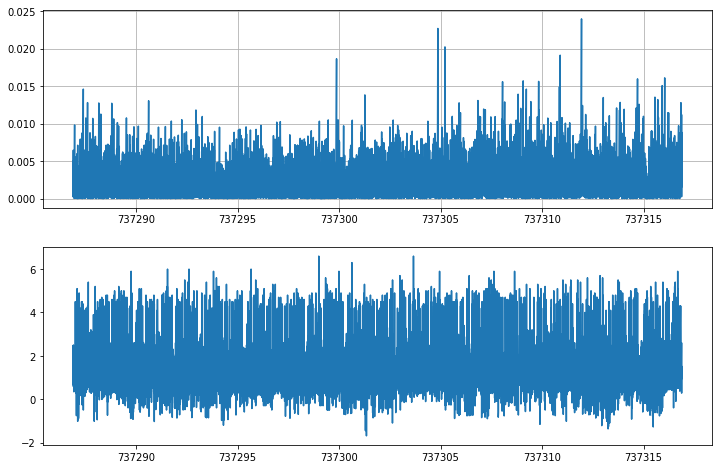

In [195]:
import pylab as plt

fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212', sharex=ax1)
ax1.grid()
#
ax1.plot(ary['event_date_float'][1:], numpy.diff(ary['event_date_float']), ls='-', marker='')
ax2.plot(ary['event_date_float'], ary['mag'])

In [89]:
for rw in obj.f:
    print('*** ', rw)

print('** ', obj.f)
obj.f.close()
#    print('** ', rw)

***  b'time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource\n'
***  b'2019-09-13T06:50:21.890Z,36.6031667,-121.202,6.03,3.82,mw,61,66,0.03413,0.09,nc,nc73271485,2019-09-14T15:37:36.985Z,"10km NNW of Pinnacles, CA",earthquake,0.15,0.43,,5,reviewed,nc,nc\n'
***  b'2019-09-10T20:21:49.840Z,33.594,-117.27,13.69,3.96,ml,178,21,0.06253,0.23,ci,ci38824959,2019-09-14T17:24:46.190Z,"1km ESE of Wildomar, CA",earthquake,0.12,0.29,0.151,333,reviewed,ci,ci\n'
***  b'2019-09-10T12:24:42.590Z,39.5272,-116.4999,9.4,3.8,ml,44,85.35,0.872,0.2833,nn,nn00703221,2019-09-11T12:25:50.008Z,"46km E of Austin, Nevada",earthquake,,2.7,0.21,17,reviewed,nn,nn\n'
***  b'2019-09-10T04:25:55.631Z,39.5419,-116.5599,9.1,4.6,ml,53,67.17,0.857,0.2275,nn,nn00703188,2019-09-11T04:27:01.615Z,"45km E of Austin, Nevada",earthquake,,2.2,0.27,23,reviewed,nn,nn\n'
***  b'2019-09-08T14:07:23.340Z,35.5815,-117.4133333,5.57,3.

In [25]:
#
def getANSStoFilehandler(lon=[-125, -115], lat=[32, 45], minMag=4.92, dates0=[dtm.datetime(2001,1,1, tzinfo=tzutc), dtm.datetime(2010, 12, 31, tzinfo=tzutc)], Nmax=999999):
    # fetch data from ANSS; return a file handler.
    #
    # use urllib in "post" mode. an example from http://www.python.org/doc/current/library/urllib.html#urllib.FancyURLopener)
    # using "get" (aka, query-string method; note the ?%s string at the end of the URL, this is a single pram call to .urlopen):
    #
    #>>> import urllib
    #>>> params = urllib.urlencode({'spam': 1, 'eggs': 2, 'bacon': 0})
    #>>> f = urllib.urlopen("http://www.musi-cal.com/cgi-bin/query?%s" % params)
    #>>> print f.read()
    #
    # using "post" (note this is a 2 pram call):
    #>>> import urllib
    #>>> params = urllib.urlencode({'spam': 1, 'eggs': 2, 'bacon': 0})
    #>>> f = urllib.urlopen("http://www.musi-cal.com/cgi-bin/query", params)
    #>>> print f.read()
    #
    # make ANSS prams dictionary (thank james for the bash-template):
    # ANSSquery has day-resolution:
    # revision: ANSS has time resolution, but you have to replace "-" -> "/" and the " " (space) -> ","
    #dates=[dtm.date(dates0[0].year, dates0[0].month, dates0[0].day), dtm.date(dates0[1].year, dates0[1].month, dates0[1].day)]
    dates=dates0
    datestr1 = anssDateStr(dates[0])
    datestr2 = anssDateStr(dates[1])
    #print datestr1, datestr2
    #
    #anssPrams={'format':'cnss', 'output':'readable', 'mintime':str(dates[0]).replace('-', '/'), 'maxtime':str(dates[1]).replace('-', '/'), 'minmag':str(minMag), 'minlat':lat[0], 'maxlat':lat[1], 'minlon':lon[0], 'maxlon':lon[1], 'etype':'E', 'searchlimit':Nmax}
    # so this is better, but i think it is still limited to 1 second resolution.
    #
    anssPrams={'format':'cnss', 'output':'readable', 'mintime':datestr1, 'maxtime':datestr2, 'minmag':str(minMag), 'minlat':lat[0], 'maxlat':lat[1], 'minlon':lon[0], 'maxlon':lon[1], 'etype':b'E', 'searchlimit':Nmax}
    #anssPrams={'format':b'cnss', 'output':b'readable', 'mintime':bytearray(datestr1, 'utf-8'), 'maxtime':bytearray(datestr2, 'utf-8'), 'minmag':bytearray(str(minMag), 'utf-8'), 'minlat':lat[0], 'maxlat':lat[1], 'minlon':lon[0], 'maxlon':lon[1], 'etype':b'E', 'searchlimit':Nmax}
    #print "debug: ", anssPrams
    #post_data = urllib.parse.urlencode(anssPrams)
    #binary_post_data = post_data.encode('ascii')
    #
    # now, let's support some backwards compatibility, at least for a little while:
    if sys.version_info.major == 2:
        # old python...
        f = urllib.urlopen('http://www.ncedc.org/cgi-bin/catalog-search2.pl', urllib.urlencode(anssPrams))
    else:
        binary_post_data = urllib.parse.urlencode(anssPrams).encode('ascii')
        f = urllib.request.urlopen('http://www.ncedc.org/cgi-bin/catalog-search2.pl', binary_post_data )
    #
    # we might return f, a string of f, or maybe a list of lines from f. we'll work that out shortly...
    return f

In [18]:
import urllib.urlretrieve

ModuleNotFoundError: No module named 'urllib.urlretrieve'

In [ ]:
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2019-09-06%2000:00:00&endtime=2019-09-13%2023:59:59&
        maxlatitude=35&minlatitude=31&maxlongitude=-113&minlongitude=-118&minmagnitude=2.5&maxmagnitude=9&
        mindepth=-1&maxdepth=300&eventtype=earthquake&orderby=time&limit=500
        

https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2019-09-01%2000:00:00&endtime=2019-09-14%2006:16:43&
                    minmagnitude=3.5&minlatitude=32.0&maxlatitude=45.0&minlongitude=-125.0&maxlongitude=-115.0&
                    eventtype=earthquake&orderby=time&limit=500
                    
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2019-09-01%2000:00:00&endtime=2019-09-14%2006:16:43&limit=500&minmagnitude=3.5
                    
                    

In [236]:
# i still don't get what this does. do not appear to be any data here... don't appear to be able to iterate.
#
data_urlr=urllib.request.urlretrieve(obj.url_str)

    len(data_urlr)

for rw in data_urlr:
        print('** ', rw)

print(data_urlr.count)
print(data_urlr.index)

<built-in method count of tuple object at 0x12a3dc688>
<built-in method index of tuple object at 0x12a3dc688>
